# Packages and required files

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from os import getenv

# Visualization and calculation tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
from plot import plot_gmap, plot_plotly

from importdata import import_data

from locations import location

# Import data


In [4]:
D=import_data("./data/raw_data")

In [5]:
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10442 entries, 0 to 10441
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_men              10442 non-null  int64  
 1   culture_label       10442 non-null  object 
 2   production_kg       10442 non-null  int64  
 3   superficie          10442 non-null  float64
 4   villages            10442 non-null  object 
 5   taille_menage       10442 non-null  int64  
 6   age                 10442 non-null  int64  
 7   nbre_heure_travail  10442 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 734.2+ KB


In [6]:
D.head()

id_men culture_label  production_kg  superficie villages  taille_menage  \
0       1      Arachide           1500         3.0   Ngouye             15   
1       1          Mais            500         1.0   Ngouye             15   
2       1           Mil           1100         2.0   Ngouye             15   
3       2      Arachide            750         1.0   Tuabou              3   
4       2          Mais           1000         1.0   Tuabou              3   

   age  nbre_heure_travail  
0   50                  28  
1   50                  28  
2   50                  28  
3   73                   0  
4   73                   0

# Data processing

## Drop duplicate rows IF ANY

In [7]:
D.drop_duplicates(inplace=True)

In [8]:
D.shape

(10442, 8)

# Missing values imputation

In [9]:
D.isnull().sum()

id_men                0
culture_label         0
production_kg         0
superficie            0
villages              0
taille_menage         0
age                   0
nbre_heure_travail    0
dtype: int64

No missing value

# Descriptive Statistics 

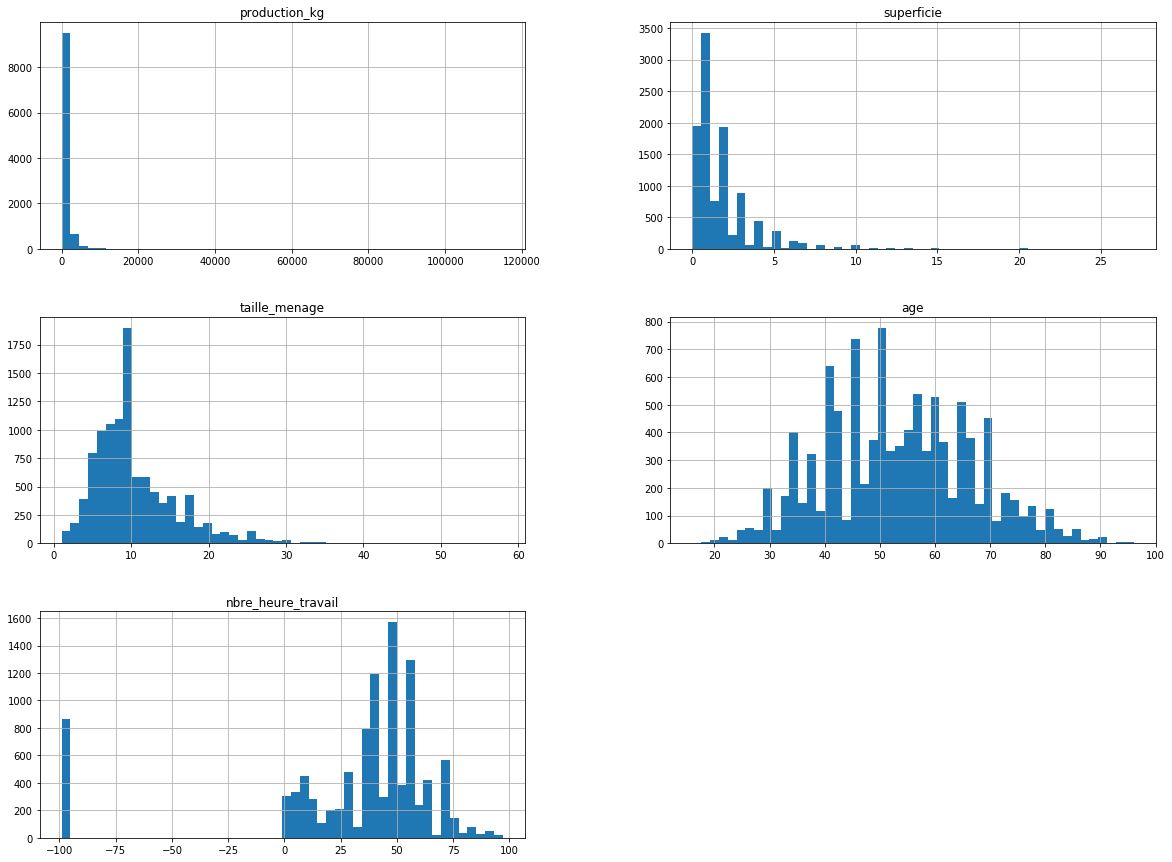

In [10]:
%matplotlib inline  
(D[["production_kg", "superficie", "taille_menage", "age", "nbre_heure_travail"]]
.hist(bins = 50, figsize = (20, 15))
)
plt.show()

### Age

In [11]:
D['age'].describe()

count    10442.000000
mean        53.240567
std         13.463938
min         16.000000
25%         43.000000
50%         52.000000
75%         63.000000
max         96.000000
Name: age, dtype: float64

The age of the farm land owners varies from 16 to 96 years, more than half of the owners are over 50 years old.

### Working duration

In [12]:
D['nbre_heure_travail'].describe()

count    10442.000000
mean        30.739705
std         43.291820
min        -99.000000
25%         25.000000
50%         42.000000
75%         55.000000
max         97.000000
Name: nbre_heure_travail, dtype: float64

I do not really know what this variable (nbre_heure_travail) measures, is it the duration of work (in hours) per week ? per 2 weeks ?...
Furthermore it takes some negative values.

It would be preferable to get rid of this variable. But since there are not many variables, let us first look at the extent of anomaly in the observations.

In [13]:
len(D[D["nbre_heure_travail"]<=0]["id_men"])/len(D['id_men'])

0.10946178892932389

In [14]:
len(D[D["nbre_heure_travail"]<=0]["id_men"].unique())/len(D['id_men'].unique())

0.10357142857142858

It represents around $10\%$ of the data and affects $10\%$ of the land owners. We decide to keep the variable nbre_heure_travail and replace the negative values by the mean 

In [15]:
D.loc[D[D['nbre_heure_travail']<=0].index, "nbre_heure_travail"] = D[D['nbre_heure_travail']>0]['nbre_heure_travail'].median()

### Production

In [16]:
D['production_kg'].describe()

count     10442.000000
mean        992.533902
std        2353.517137
min           0.000000
25%         200.000000
50%         500.000000
75%        1000.000000
max      115000.000000
Name: production_kg, dtype: float64

On average 992.5 kilograms are produced overall 

In [17]:
zero_production=D[D["production_kg"]<=0]
print("{} % of the farm owners produce nothing for a specific culture".format(round(100*len(zero_production["id_men"].unique())/len(D["id_men"].unique()), 1)))

4.7 % of the farm owners produce nothing for a specific culture


We decide to drop those data

In [18]:
D.drop(index=zero_production.index, inplace=True)
D.shape

(10198, 8)

### Area

In [19]:
D['superficie'].describe()

count    10198.000000
mean         1.896069
std          1.985660
min          0.001420
25%          1.000000
50%          1.000000
75%          2.000000
max         27.000000
Name: superficie, dtype: float64

I do not know the exact unit of the area, the hectare unit (i.e. 10.000 square meters) makes sense to me because in that case the average production per square meter will be $\approx \frac{1000}{20.000} = 0.05 kg.m^{-2}$ 

In [20]:
print("mean production = %f kg/square meters" % (round(np.mean(D['production_kg']/(D['superficie']*10**(4))), 2) ) )

mean production = 0.070000 kg/square meters


### Household size

In [21]:
D['taille_menage'].describe()

count    10198.000000
mean        10.430575
std          5.625461
min          1.000000
25%          7.000000
50%          9.000000
75%         13.000000
max         58.000000
Name: taille_menage, dtype: float64

### Production type/culture label

In [22]:
D['culture_label'].describe()

count        10198
unique          32
top       Arachide
freq          3068
Name: culture_label, dtype: object

There are 32 cultures types, an peanuts are produced by most of the farmers.

In [23]:
D['culture_label'].value_counts()[:5]

Arachide    3068
Mil         2675
Mais        1510
Niebe        953
Riz          835
Name: culture_label, dtype: int64

### Adding the longitude and latitude of the villages

I get the latitude and the longitude of the villages using Google Maps API.  I set an environment variable named google_key which stores my google api key.

In [24]:
my_key=getenv("google_key") 

In [25]:
villages = D["villages"].unique()
villages_location=location(villages,my_key)
villages_location.head(2)

villages        lat        lng
0   Ngouye  14.367150 -16.441645
1   Tuabou  14.866557 -15.899496

### Mapping the villages

In [26]:
plot_plotly(villages_location)

In [27]:
data=pd.merge(D, villages_location, on=["villages"], how="left")
data.drop(columns=["villages"], inplace=True)
data.head(2)

id_men culture_label  production_kg  superficie  taille_menage  age  \
0       1      Arachide           1500         3.0             15   50   
1       1          Mais            500         1.0             15   50   

   nbre_heure_travail       lat        lng  
0                  28  14.36715 -16.441645  
1                  28  14.36715 -16.441645

In [28]:
print( "Ratio of rows with NaNs latitude or longitude: %f" % (len(data[data["lat"].isna()| data['lng'].isna()])/len(data)) )

Ratio of rows with NaNs latitude or longitude: 0.197882


We drop those rows

In [29]:
data.drop(index=data[data["lat"].isna()| data['lng'].isna()].index, inplace=True)
data.shape

(8180, 9)

In [30]:
data.to_csv("./data/cleaned_data/processed_data.csv" ,index=False)

### Polynomial Regression

In [40]:
poly_reg = Pipeline([
    ('polynomial_features' , PolynomialFeatures(degree=3, include_bias=False)),
    ('lin_reg' , LinearRegression())
])

poly_reg.fit(data_X, data_Y)

Pipeline(memory=None,
         steps=[('polynomial_features',
                 PolynomialFeatures(degree=3, include_bias=False,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [41]:
rmse(data_Y, poly_reg.predict(data_X))

969.2438425974909

#### Cross validation (k fold)

In [42]:
kfold(Pipeline([
    ('polynomial_features' , PolynomialFeatures(degree=3, include_bias=False)),
    ('lin_reg' , LinearRegression())
              ]), data_X, data_Y, 20)

Scores [1410.45932739  660.47629295  693.14995459  755.25268118  809.15331162
  917.36025498  794.33021527 1404.07593624  639.62965901  551.47850843
  772.55362058 1038.55042454  792.84164709  664.57617016 2379.84564816
  772.6829993   545.10993403 1214.89223691  738.55386739  699.69159672]
Average score 912.7332143271035
Standard deviation of scores 414.8072265240002


The model does not seem stable also.

#### Learning Curve

In [43]:
plot_learning_curve(poly_reg, data_X, data_Y, nb_training=100)

### Decision Tree

In [44]:
tree_reg = DecisionTreeRegressor(max_depth = 5)
tree_reg.fit(data_X, data_Y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

#### Cross validation

In [45]:
kfold(DecisionTreeRegressor(max_depth = 5), data_X, data_Y, 20)

Scores [1352.34324154  951.44472887  707.73364656 1097.98043485  862.24610339
  953.45189961  810.10041079 1440.37640508  623.25326339  625.93509607
  648.28989425 1080.54608391  815.63857855  776.60259319 2446.98151256
 2485.20969666  504.09350232 1729.75564622  652.88832843  713.620107  ]
Average score 1063.9245586621084
Standard deviation of scores 555.3128841533111


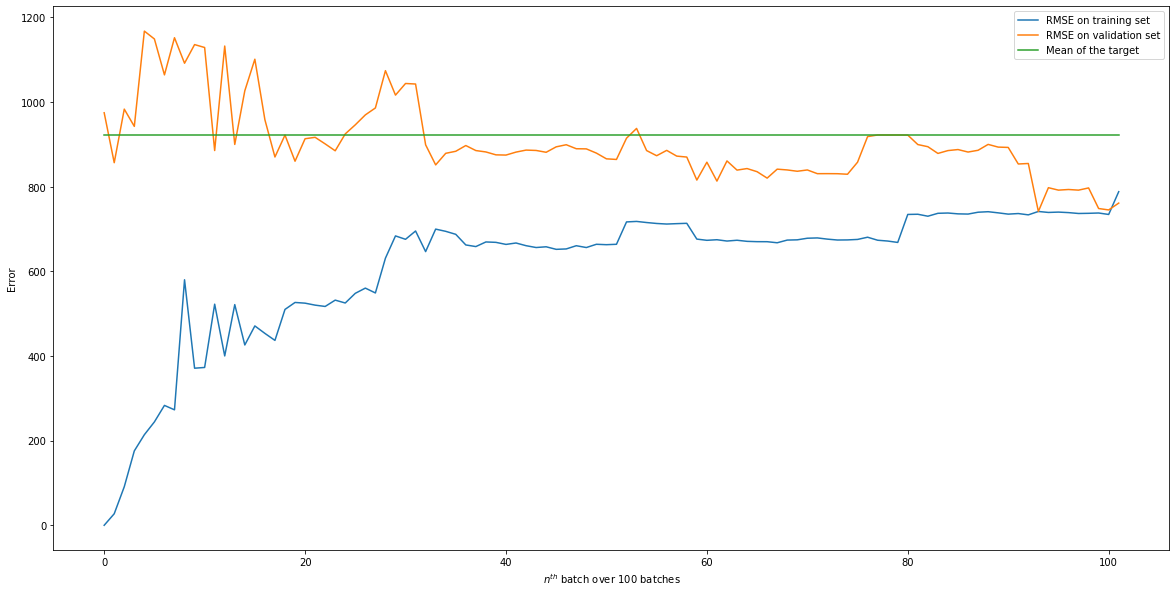

In [46]:
plot_learning_curve(DecisionTreeRegressor(max_depth = 5), data_X, data_Y, nb_training=100)

The model seems to overfit the data because it perform way better on the training set that the validation one

### Comparing the models

In [47]:
models=[lin_reg, tree_reg, poly_reg]
test_X,test_Y=test[["superficie", "taille_menage", "age", "nbre_heure_travail"]],test['production_kg']
test_models(models, test_X, test_Y)

Features       Errors
0       LinearRegression   890.100929
1  DecisionTreeRegressor  1007.014376
2               Pipeline  1508.605875

## Nonparametric econometrics approach

We use a simple model where we only take into account the area as regressor.

In [48]:
import time as time
# Nadarya Watson estimation
var = ["superficie"]
Y = np.array(data_Y)
X = np.array(data_X[var])
start = time.time()
np_reg  = kernel_regression.KernelReg(endog = Y, exog = X, var_type = 'c'*X.shape[1])
print("The model took {} seconds to run".format(round(time.time()-start,2)))

The model took 30.4 seconds to run


In [49]:
# Estimated Bandwidth
np_reg.bw

array([0.85357741])

### Cross validation

In [50]:
cv_np_reg(data_X[var], data_Y, k=3)

1 validation(s) made
2 validation(s) made
3 validation(s) made
Scores [1314.08199156  887.31759252  759.42331096]
Average score 986.9409650134534
Standard deviation of scores 237.14296004662043


In [51]:
rmse_np_reg_train = rmse(np_reg.fit(train[var])[0], train[["production_kg"]])

rmse_np_reg_test = rmse(np_reg.fit(test[var])[0], test[["production_kg"]])
print(rmse_np_reg_train, rmse_np_reg_test)

984.6162143973642 869.2481307646962


The Nadarya Watson regression seems to outperform the previous models in terms of rmse, with one predictor. However it takes more time to run

# Conclusions

The linear regression seems to yield good predictions, the Nadarya Watson regression also. However we do not know how these predictions would behave in time. It would be more interesting to get more data, more variables and especially time series data in order to see the evolution of the predictions quality over time and how stationary they are.